In [1]:
# Import Libraries

import pandas as pd
import smact

In [2]:
# Load the dataset

df = pd.read_csv("../../data/d1_data_extraction/material_data.csv")

# Extracting Required Columns
df = df[['Formula']]

In [3]:
# Handling Duplicates

print("Shape Before Remvoing Duplicates: ", df.shape)

# Removing Duplicates
data_unique = df.drop_duplicates(subset='Formula', keep='first').sort_values(by='Formula')

# Checking Shape after removing
print("Shape After removing Duplicates: ", data_unique.shape)


Shape Before Remvoing Duplicates:  (153235, 1)
Shape After removing Duplicates:  (104039, 1)


In [4]:
# Handling Missing Values

print(data_unique.isna().sum())

data_unique = data_unique.dropna()

print(data_unique.isna().sum())

Formula    1
dtype: int64
Formula    0
dtype: int64


In [5]:
# Removing Formulas having atoms > 20
import pandas as pd

def has_number_gt_20(formula):
    numbers = []
    num = ''
    for char in formula:
        if char.isdigit():
            num += char
        elif num:
            numbers.append(int(num))
            num = ''
    if num:
        numbers.append(int(num))
    return any(num > 20 for num in numbers)

# Filter out rows with numbers greater than 20 in the Chemical_Formula column
df_filtered = data_unique[~data_unique['Formula'].apply(has_number_gt_20)]

print("Shape before removing:", data_unique.shape)
print("Shape after removing:", df_filtered.shape)

Shape before removing: (104038, 1)
Shape after removing: (98561, 1)


In [6]:
# One Hot Representation for filtered data

# Get all elements as a list
atomic_symbols = smact.ordered_elements(1, 103)

def formula_to_one_hot(formula):
    """
    Converts a chemical formula to a one-hot vector representation.
    """
    one_hot = [[0] * len(atomic_symbols) for _ in range(20)]  # Initialize with 20 rows (0 to 19)

    def parse_formula(formula, multiplier=1):
        i = 0
        while i < len(formula):
            char = formula[i]

            if char.isalpha():
                if i + 1 < len(formula) and formula[i + 1].islower():
                    symbol = char + formula[i + 1]
                    i += 1  # Move to the next character
                else:
                    symbol = char

                if symbol in atomic_symbols:
                    column = atomic_symbols.index(symbol)
                    row = 1

                    if i + 1 < len(formula) and formula[i + 1].isdigit():
                        j = i + 1
                        num_str = ''
                        while j < len(formula) and formula[j].isdigit():
                            num_str += formula[j]
                            j += 1
                        row = int(num_str)
                        i = j - 1  # Move to the last digit character

                    # row *= multiplier
                    row = min(row * multiplier, 19)
                    one_hot[row - 1][column] = 1

            elif char == '(':
                j = i + 1
                sub_formula = ''
                while formula[j] != ')':
                    sub_formula += formula[j]
                    j += 1
                i = j

                sub_multiplier = 1
                if i + 1 < len(formula) and formula[i + 1].isdigit():
                    num_str = ''
                    j = i + 1
                    while j < len(formula) and formula[j].isdigit():
                        num_str += formula[j]
                        j += 1
                    sub_multiplier = int(num_str)
                    i = j - 1

                parse_formula(sub_formula, multiplier * sub_multiplier)

            i += 1

    parse_formula(formula)

    return one_hot

# Generate one-hot vector representations
ohv = df_filtered['Formula'].apply(formula_to_one_hot)


# **Generation Model**

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

In [8]:
# Prepare the data
ohv_train = np.array(ohv.tolist()).astype('float32')
ohv_train /= np.max(ohv_train)

In [9]:
# Define the Generator
def build_generator_with_constraints(latent_dim):
    init = RandomNormal(mean=0.0, stddev=0.02)
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(latent_dim,)))
    model.add(layers.Dense(256, kernel_initializer=init))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.3))  # Regularization - Dropout
    model.add(layers.Dense(512, kernel_initializer=init))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.3))  # Regularization - Dropout
    model.add(layers.Dense(20 * 103, activation='sigmoid'))
    model.add(layers.Reshape((20, 103)))
    return model

def generate_with_constraints(generator, noise, max_ones=5):
    generated = generator.predict(noise)
    generated = (generated > 0.5).astype(int)
    constrained_matrices = []

    for matrix in generated:
        constrained_matrix = np.zeros_like(matrix)
        num_ones = np.random.randint(1, max_ones + 1)
        cols = np.random.choice(range(103), num_ones, replace=False)
        for col in cols:
            row = np.random.choice(range(8), 1) 
            constrained_matrix[row, col] = 1
        constrained_matrices.append(constrained_matrix)

    return np.array(constrained_matrices)

In [10]:
# Define the Discriminator with LeakyReLU and Dropout
def build_discriminator():
    init = RandomNormal(mean=0.0, stddev=0.02)
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(20, 103)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, kernel_initializer=init))
    model.add(layers.LeakyReLU(negative_slope=0.2))  # Updated to use negative_slope
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256, kernel_initializer=init))
    model.add(layers.LeakyReLU(negative_slope=0.2))  # Updated to use negative_slope
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(128, kernel_initializer=init))
    model.add(layers.LeakyReLU(negative_slope=0.2))  # Updated to use negative_slope
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [11]:
# Set up the GAN
latent_dim = 100  # Dimension of the noise vector

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5), metrics=['accuracy'])

# Build the generator with constraints
generator = build_generator_with_constraints(latent_dim)

# Build and compile the GAN
z = layers.Input(shape=(latent_dim,))
generated_formula = generator(z)
discriminator.trainable = False
validity = discriminator(generated_formula)
gan = Model(z, validity)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5))

In [12]:
# Print model summaries
generator.summary()
discriminator.summary()
gan.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │        25,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2060)           │     1,056,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 20, 103)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217,292 (4.64 MB)

 Trainable params: 1,215,756 (4.64 MB)

 Non-trainable params: 1,536 (6.00 KB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2060)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,055,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,219,585 (4.65 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,219,585 (4.65 MB)

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 20, 103)        │     1,217,292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 1)              │     1,219,585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,436,877 (9.30 MB)

 Trainable params: 1,215,756 (4.64 MB)

 Non-trainable params: 1,221,121 (4.66 MB)

In [13]:
import matplotlib.pyplot as plt

# Training Function with Loss Logging
def train_gan(gan, generator, discriminator, data, epochs, batch_size, latent_dim):
    half_batch = batch_size // 2
    d_accuracies = []

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_formulas = data[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        generated_formulas = generate_with_constraints(generator, noise)

        real_labels = np.ones((half_batch, 1))
        fake_labels = np.zeros((half_batch, 1))

        discriminator.trainable = True
        d_loss_real, d_acc_real = discriminator.train_on_batch(real_formulas, real_labels)
        d_loss_fake, d_acc_fake = discriminator.train_on_batch(generated_formulas, fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        d_accuracies.append(d_acc)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))

        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, valid_y)

        print(f"{epoch} [D loss: {d_loss}, D accuracy: {d_acc*100:.2f}%, G loss: {g_loss}]")

    # Plotting Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), d_accuracies, label='Discriminator Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('GAN Training Accuracy')
    plt.legend()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
0 [D loss: 0.6930211782455444, D accuracy: 46.09%, G loss: 0.6849641799926758]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1 [D loss: 0.6934192180633545, D accuracy: 44.92%, G loss: 0.6856696605682373]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2 [D loss: 0.6933391094207764, D accuracy: 46.41%, G loss: 0.6853427290916443]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3 [D loss: 0.6933705806732178, D accuracy: 45.40%, G loss: 0.6853857636451721]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4 [D loss: 0.6933887004852295, D accuracy: 46.77%, G loss: 0.6854887008666992]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
5 [D loss: 0.6933940649032593, D accuracy: 47.21%, G loss: 0.6844210624694824]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6 [D loss: 0.6934149265289307, D accuracy: 46.88%, G loss: 0.6830393075942993]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7 [D loss: 0.6933689117431641, D accuracy: 47.40%, G loss: 0.6821958422660828]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8 [D loss: 0.693325996398

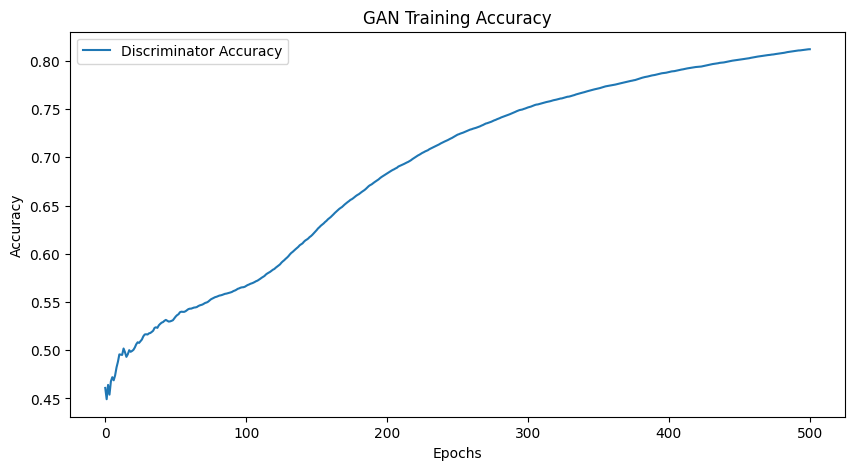

In [14]:
# Train the Model

# Hyperparameters
epochs = 501
batch_size = 64
latent_dim = 100

# Train the GAN
train_gan(gan, generator, discriminator, ohv_train, epochs, batch_size, latent_dim)

In [15]:
# Generate new samples with constraints
noise = np.random.normal(0, 1, (100000, latent_dim))
generated_matrices = generate_with_constraints(generator, noise, max_ones=5)

generated_matrices = (generated_matrices > 0.5).astype(int)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step


In [ ]:
import csv
import periodictable

# Get all elements as a list
# elements_list = periodictable.elements

# Extract only the symbols from the elements list and filter out 'n'
# atomic_symbols = [element.symbol for element in elements_list if element.symbol != 'n']

# Get all elements as a list
atomic_symbols = smact.ordered_elements(1, 103)

def matrix_to_formula(dense_matrix):
    """
    Converts a matrix back to a chemical formula.
    """
    formula = ''
    for row_idx, row in enumerate(dense_matrix):
        for col_idx, val in enumerate(row):
            if val == 1:
                symbol = atomic_symbols[col_idx]
                atoms = row_idx + 1
                if atoms > 1:
                    formula += f"{symbol}{atoms}"
                else:
                    formula += symbol
    return formula

# Convert dense matrices back to formulas
formulas = []
for i, matrix in enumerate(generated_matrices):
    formula = matrix_to_formula(matrix)
    formulas.append({'Formula': formula})

# Save formulas to CSV file
csv_file = '../../data/d2_data_generation/generated_formulas.csv'
fieldnames = ['Formula']

with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(formulas)

print(f"Formulas saved to {csv_file}.")
